In [1]:
%matplotlib inline

import sys, os
sys.path.append(os.path.abspath("..")) # add parent directory for import

# Chapter 2 : Data Fitting

Model fitting is when we use a theoretical model to fit experimental data, in the hope that:
1. Our model can faithfully replicate the experimental data (i.e a "good" fit)
1. The model parameters that provide the aforementioned good fit tell us something informative

Itcsimlib can help you satisfy only the first problem. The second, and much more philosophical one, is an _exercise left to the reader_.

To import experimental data, you have two choices:
1. Import a processed .nitpikl file from NITPIC
1. Generate your own from available data using itcsimlib's basic file format, as seen in "chapter_2_experiment.txt"

Note that unlike Python scripts, itcsimlib does not entirely ignore the lines in an experimental data file that start with a pound (#) sign, as it uses these lines to store some valuable information. Let's look at the first several lines of chapter_2_example.txt in the tutorial folder:

```
# units kcal
# T	298.15000
# V0	1416.60000
# Cell	Macromolecule	1.00000E-06
# Syringe	Ligand	2.00000E-05
# Q_dil	0.00000E+00
```

`T`, as you may gather, is the temperature the experiment took place at.

`V0`, as we saw in Chapter 1, is the cell volume.

Lines that start with `Syringe` tell itcsimlib what model components were present in the syringe solution. Here, we see that the Ligand component was present at 20 micromolar.

Lines that start with `Cell`, on the other hand, tell itcsimlib what the (starting) concentration of the named component was in the cell. Over the course of the titration, this will obviously be diluted a bit as we titrate in syringe components.

Note that it's possible to have the same component in both the syringe and the cell, potentially even at different concentrations. However, components that are not specifically acted upon by the model will be ignored.

In [2]:
from itcsimlib import *

sim = ITCSim(T0=298.15,units="kcal",verbose=True)

experiment1 = sim.add_experiment_file('chapter_2_example_298K.txt', skip=[0])

**Note**: Any header fields in the experiment file that start with the pound sign followed by a space are automatically passed on by the `add_experiment_file()` function, so we don't have to manually provide arguments.

If we wish to override parameters provided by the file such the experimental temperature, we can simply provide them as additional arguments to `add_experiment_file()`, e.g. `add_experiment_file("file.txt", T=298.15)`

In the above experiment, the only extra argument we provided was the `skip` argument, which tells itcsimlib to ignore specific injection points, in this case just the first injection.

To fit this data, let's use a very simple model that describes a single binding mode:

In [3]:
from itcsimlib.model_independent import OneMode

sim.set_model( OneMode() )

Because this model is a very simple one with only one binding mode it has only four parameters:
* Stoichiometry: n, i.e. the number of sites that bind with this mode.
* Affinity: $\Delta G$, i.e. the free energy change upon binding.
* Enthalpy: $\Delta H$, i.e. the enthalpy change upon binding.
* Heat capacity: $\Delta C_{p}$, i.e. the heat capacity change upon binding, which affects both $\Delta G$ and $\Delta H$.

Using any of a number of optimization algorithms, itcsimlib can optimize any (or all) of these parameters to values that minimize the discrepancy between the specified model experimental data. itcsimlib can also handle more specialized models, e.g. such as reducing the number of parameters by assuming that both modes have the same change in heat capacity. To see how this can be done, see tutorial Chapter 4.

Numerical optimization of model parameters _IS NOT MAGIC_. If you have bad (i.e. unreasonable) starting conditions, then numerical optimization can either fail outright, or you'll converge to a local minimum. Even if you start with a decent set of starting conditions, you may still converge to a local minimum. There's simply not enough space in this tutorial to describe the numerous potential pitfalls presented by numerical optimization/fitting, but grid fitting, in which parameters are systematically varied is described in tutorial chapter ?.

Let's set the starting conditions to a reasonable guess of 2 binding sites with ~1$\mu$M $K_{d}$ and a -10 kcal/mol enthalpy change. Since we're only analyzing a single temperature, our change in heat capacity can be zero:

In [4]:
sim.set_model_params(n=2, dG=-10, dH=-10, dCp=0)

It's always a good idea to make an initial starting condition fit plot. Don't forget to run the simulator first!

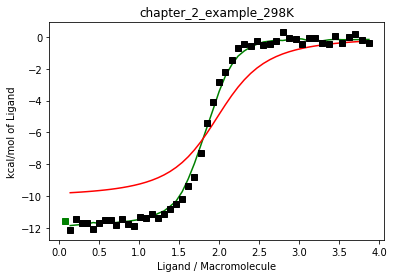

In [5]:
sim.run()
sim.make_plots()

Here, the green line is the spline interpolated through the points by itcsimlib, and the red line is our initial model fit. Not great, but not completely terrible either, so a good starting point for further optimization.

The actual parameter optimization, i.e. fitting, is carried out by an ITCFit object. We instantiate one and tell it what simulation to optimize:

In [6]:
fit = ITCFit( sim, verbose=True )

We have to tell the fitter's optimize method what parameters we'd like to optimize, and the optimize method will return the optimized parameters and the final chi-square goodness-of-fit. The latter we can use later, e.g. by writing to a file, or using as the starting conditions for a different fit.

In [7]:
optimized_params,chisq = fit.optimize( params=['n','dG','dH'])


itc_fit: Optimizing n,dG,dH parameters using the simplex algorithm

Optimization terminated successfully.
         Current function value: 0.477407
         Iterations: 62
         Function evaluations: 117


A chi-square of less than 1.0 suggests we are overfitting the data somewhat, i.e. that our model is more sophisticated than necessary.

Let's add some additional experimental data acquired at different experimental temperatures:

In [8]:
experiment2 = sim.add_experiment_file('chapter_2_example_288K.txt', skip=[0])
experiment3 = sim.add_experiment_file('chapter_2_example_308K.txt', skip=[0])

We should likely update our model with the parameters we optimized with the fit to just the 298K data:

In [9]:
sim.set_model_params( **optimized_params )

Now that we have multiple temperatures, we'll likely need to take into account the potential effects a change in heat capacity can have on the affinity and enthalpy of binding.

We can see how much of an effect ignoring a change in heat capacity has by simulating the model using the parameters optimized at 298K at the other experimental temperatures.

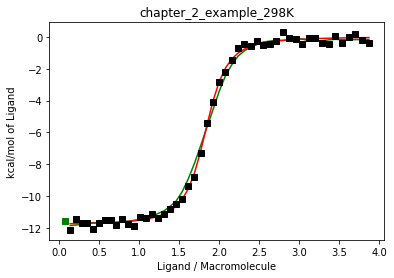

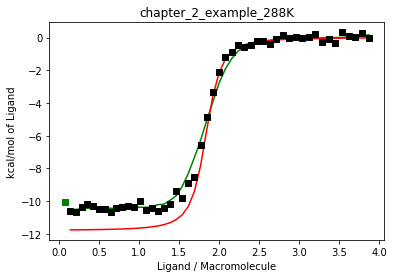

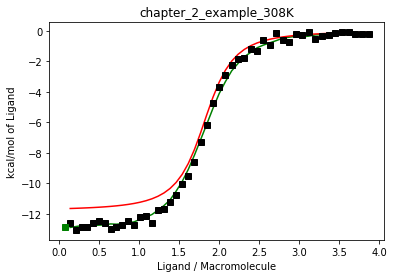

In [10]:
sim.run()
sim.make_plots()

Those fits look pretty bad, we ended up overestimating the evolved heat at the lower temperature, and underestimating it at higher temperature. Again, note that the green line in the fit plots is the spline itcsimlib uses to estimate noise in the experimental data.

We can use the two additional experimental temperatures, however, to constrain (i.e. determine) dCp:

In [11]:
optimized_dCp,chisq = fit.optimize( params=['dCp'])


itc_fit: Optimizing dCp parameters using the simplex algorithm

Optimization terminated successfully.
         Current function value: 0.506377
         Iterations: 19
         Function evaluations: 38


Now that we have the right heat capacity term, update the model and generate new plots:

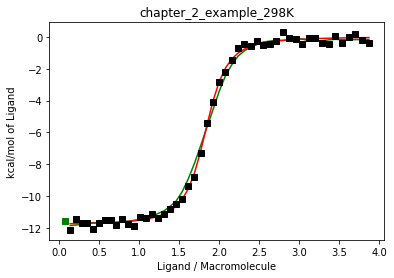

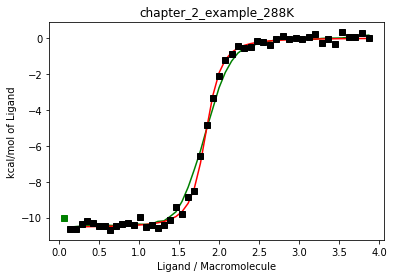

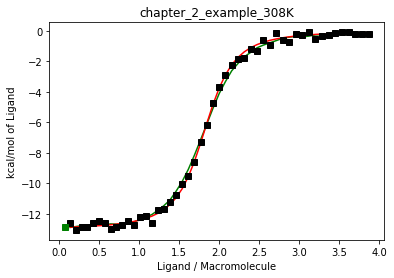

In [12]:
sim.set_model_params( **optimized_dCp )
sim.run()
sim.make_plots()

We can also write the parameters to a file in order to have a permanent copy:

In [13]:
from itcsimlib.utilities import write_params_to_file
write_params_to_file( "chapter_2_parameters.txt", params=sim.get_model_params() )

Congrats. You've reached the end of Chapter 2. In the next chapter we'll cover error estimation and gridding model parameters.

In [14]:
sim.done()